# GSEA analysis

In [94]:
library('fgsea')
library('msigdbr')
library('ggplot2')

In [35]:
paths <- list( 'KO'='subdata/IS_results_KO::young.csv', 
               'WT'='subdata/IS_results_WT::young.csv', 
               'old'='subdata/IS_results_old::young.csv')

In [131]:
species = 'mouse'
type = 'Symbol'

#fetch gene sets
m_df_h = msigdbr(species = species, category = "H")
m_df_bp = msigdbr(species = species, category = "C5",subcategory = "BP")
m_df_kegg = msigdbr(species = species, category = "C2",subcategory = "CP:KEGG")
m_df_reactome = msigdbr(species = species, category = "C2",subcategory = "CP:REACTOME")
m_df <- rbind(rbind(m_df_h, m_df_bp,m_df_kegg),m_df_reactome)
#prepare gene sets
functions_list <- levels(factor(m_df$gs_name))
functions_annotation <- list()
for (i in functions_list){
    temp_data <- m_df[m_df$gs_name==i,]
    if (type=="Symbol"){
        temp_data <- toupper(as.character(temp_data$gene_symbol))
    }else if (type=="Entrez"){
        temp_data <- as.character(temp_data$entrez_gene)      
    }
    functions_annotation[[i]] <- temp_data
}

fres <- list()
for (path in names(paths)){
    IS <- read.csv(paths[[path]])
    ranked_list <- IS[c('Name', 'ES')]
    ranked_list <- ranked_list[order(ranked_list[,2],decreasing = T),]
    ranked_vector <- ranked_list[,2]
    names(ranked_vector) <- toupper(as.character(ranked_list[,1]))
    
    res <- fgsea(pathways = functions_annotation, 
                stats    = ranked_vector,
                nperm = 10000,
                minSize  = 10,
                maxSize  = 500)
    fres[[path]] <- res
}


Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in

In [227]:
IS <- read.csv(paths[[2]])
paths[[1]]
sum(IS$ES > 0)

[1] "subdata/IS_results_KO::young.csv"

[1] 12164

In [137]:
nesdf <- data.frame(row.names=fres[['KO']]$pathway)
nesdf$KO <- fres[['KO']]$NES
nesdf$WT <- fres[['WT']]$NES
nesdf$old <- fres[['old']]$NES

pdf <- data.frame(row.names=fres[['KO']]$pathway)
pdf$KO <- fres[['KO']]$pval
pdf$WT <- fres[['WT']]$pval
pdf$old <- fres[['old']]$pval

In [159]:
cor(nesdf, use="complete.obs", method='pearson')

,KO,WT,old
KO,1.0000000,-0.1926886,0.3909611
WT,-0.1926886,1.0000000,-0.2716102
old,0.3909611,-0.2716102,1.0000000


In [202]:
#nm <- rownames(pdf[order(pdf$KO),][1:40,])
#nm <- 
cases <- c()

nm <- rownames(nesdf[sign(nesdf$old) != sign(nesdf$WT),])
print(length(nm))
tmp <- pdf[nm,]
nm <- rownames(tmp[order(tmp$WT),][1:20,])

[1] 5427


In [203]:
melt <- data.frame()
for (n in names(fres)){
    fres[[n]]$type <- paste(n, 'vs', 'young')
    melt <- rbind(melt, fres[[n]])
}

In [204]:
#submelt <- melt[grepl('HALLMARK', melt$pathway),]
submelt <- melt[melt$pathway %in% nm,]

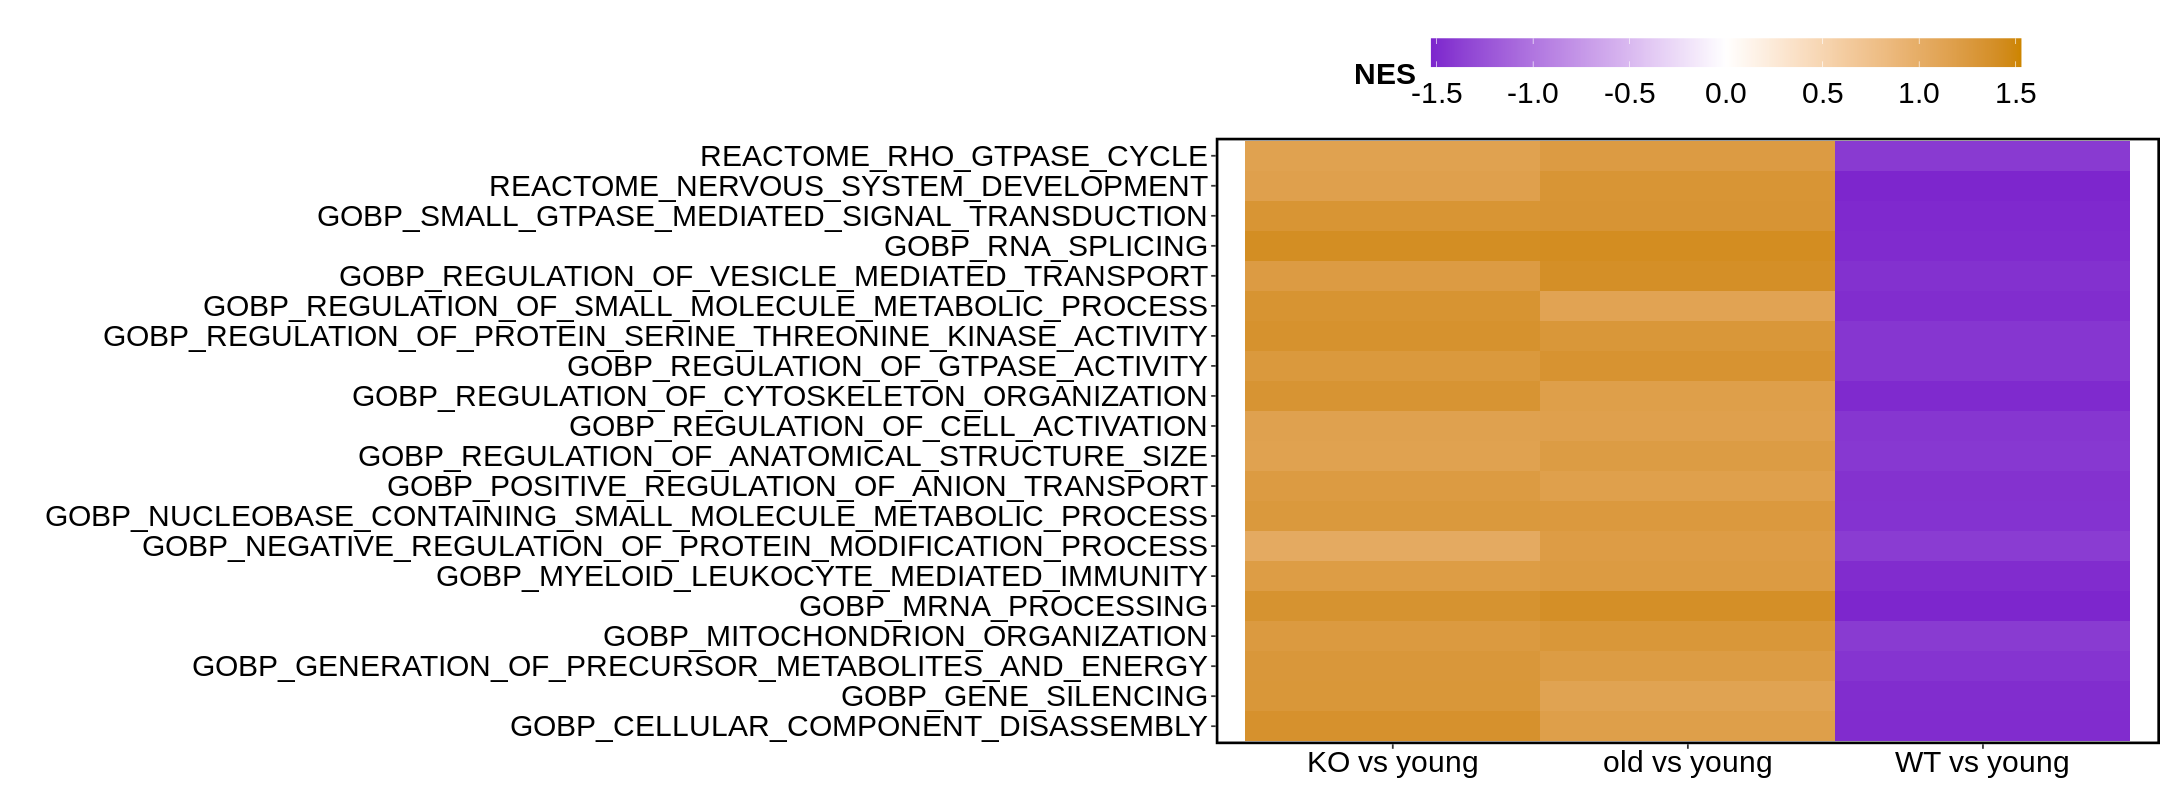

In [205]:
fontsize=18
limit <- max(abs(submelt$NES))
options(repr.plot.width = 18, repr.plot.height = nrow(submelt)/3/3)
ggplot(data=submelt, aes(x=type, y=pathway, fill=NES)) + 
    geom_tile()+
    theme(
        axis.text.y = element_text(size = fontsize, colour='black'),
        axis.text.x = element_text(size = fontsize, colour='black'),
        panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.title=element_text(size=fontsize, face = "bold"),
        legend.text=element_text(size=fontsize),
        legend.position="top", 
        legend.key.width = unit(2.5, "cm"),
        plot.margin = unit(c(0., 0., 0., 0.5), "cm")) +
    scale_fill_gradient2(
                        high="orange3", low="purple3", mid='white', 
                        limits=c(-limit, limit), 
                        midpoint=0)+
    labs(x="", y = "", title="")